In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate
import matplotlib.cm as cm

 
import csv

In [2]:
# VARIABLES

file_name = 'IC_raw_spectra_(2019_02_25_'

#path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra RACHEL
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside' #path containing all raw spectra

file_path_tau = path_raw + "/Laura_simulations"
#path_sensitivity = 'H:/MSci Project/Sensitivity_Analysis'
path_sensitivity = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside/Sensitivity_Analysis'

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [4]:
def inv_resp_function(hbb_spectrum, cbb_spectrum):
    
    V_diff = np.array(hbb_spectrum)-np.array(cbb_spectrum)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    temp_average_c = times_temps.at[cbb_index,'CBB_temp']

    radiances_avg_h = [planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut]
    radiances_avg_c = [planck(wn, float(temp_average_c)+273.15) for wn in wavenums_cut]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)

    def division(raw_val,planck_val):
        if raw_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div

    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)

    return(ratio)


def plot_planck(t, wns):
    radiances = []
    for w in wns:
        radiances.append(planck(w, t+273.15))
    return radiances

In [5]:
#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [6]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [7]:
wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


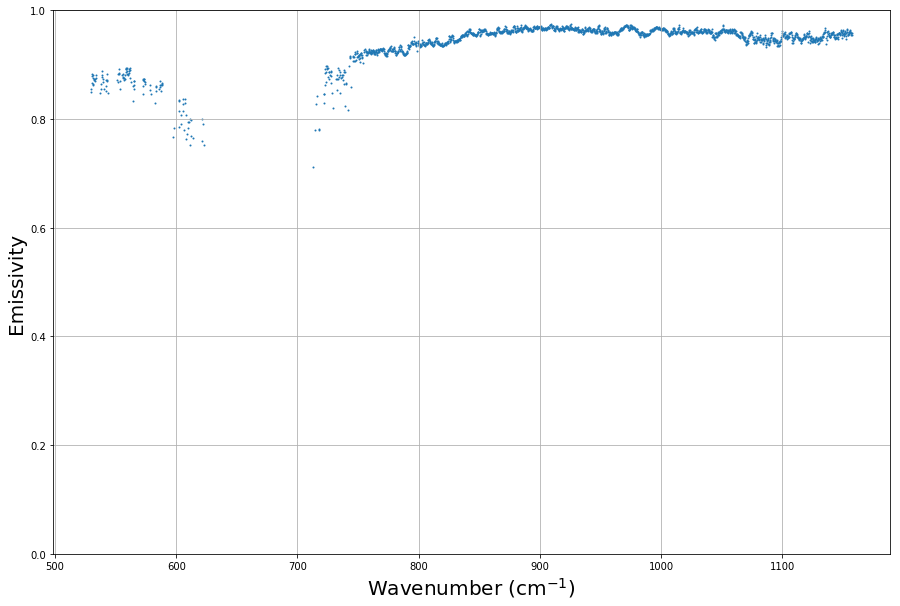

In [8]:
wavenums_cut = [wn for wn in wavenums if wn>400]
wavenums_min_ind = [i for i,x in enumerate(wavenums) if x >400][0]

plt.figure(figsize=(15,10))
all_ems = []

t_file = '2103_3063'
hbb_index = 528
cbb_index = 519
sky_index = 503
surface_index = 525
atm_t = 21.03 #21.03
surf_t = 17.3 #17.3
#time = '15:07'


hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
response = inv_resp_function(hbb_spectrum, cbb_spectrum)

temp_average_h = times_temps.at[hbb_index,'HBB_temp']
radiances_avg_h = np.array([planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut])

sky = read_raw_spectra(path_raw, files[int(np.floor(sky_index/4))])[sky_index%4][wavenums_min_ind:]
surf = read_raw_spectra(path_raw, files[int(np.floor(surface_index/4))])[surface_index%4][wavenums_min_ind:]

sky_rad = np.divide((sky-hbb_spectrum), response) + radiances_avg_h
surf_rad = np.divide((surf-hbb_spectrum), response) + radiances_avg_h

tau_wn= []
taus_rtm = []
trans_file = np.loadtxt(file_path_tau + '/' + t_file +'.txt')
for i in np.arange(trans_file.shape[0]):
    tau_wn.append(trans_file[i][0])
    taus_rtm.append(trans_file[i][1])
f_trans = interpolate.interp1d(tau_wn, taus_rtm)

downs = []
ups = []
taus = []
wns =[]
for i in range(len(wavenums_cut)):
    if f_trans(wavenums_cut[i]) >0.98:
        taus.append(f_trans(wavenums_cut[i]))
        wns.append(wavenums_cut[i])
        downs.append(sky_rad[i])
        ups.append(surf_rad[i])

BBatm = plot_planck(atm_t, wns)
BBsurf = plot_planck(surf_t, wns)

N1 = np.array(ups)
N2 = np.array([t**2*d for t, d in zip(taus, downs)])
N3 = np.array([(1-t**2)*b for t, b in zip(taus, BBatm)])

N = N1-N2-N3

D1 = np.array([t*b for t, b in zip(taus, BBsurf)])
D2 = np.array([t**2*d for t, d in zip(taus, downs)])
D3 = np.array([t*(1-t)*b for t, b in zip(taus, BBatm)])

D = D1-D2-D3

emissivity = N/D

#plt.plot([min(wns), max(wns)], [1,1], 'k--')
plt.scatter(wns, emissivity, s=1)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.ylim([0,1])

plt.grid()
plt.show()

with open(os.path.join(path_sensitivity, 'Surf_T_' + str(surf_t) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))

In [9]:
a1 = read_file(path_sensitivity, 'Surf_T_17.1.csv', separator='\t', rowstoskip=None, head=None)
a2 = read_file(path_sensitivity, 'Surf_T_17.2.csv', separator='\t', rowstoskip=None, head=None)
a3 = read_file(path_sensitivity, 'Surf_T_17.3.csv', separator='\t', rowstoskip=None, head=None)
a4 = read_file(path_sensitivity, 'Surf_T_17.4.csv', separator='\t', rowstoskip=None, head=None)
a5 = read_file(path_sensitivity, 'Surf_T_17.5.csv', separator='\t', rowstoskip=None, head=None)
a18 = read_file(path_sensitivity, 'Surf_T_18.3.csv', separator='\t', rowstoskip=None, head=None)
a16 = read_file(path_sensitivity, 'Surf_T_16.3.csv', separator='\t', rowstoskip=None, head=None)

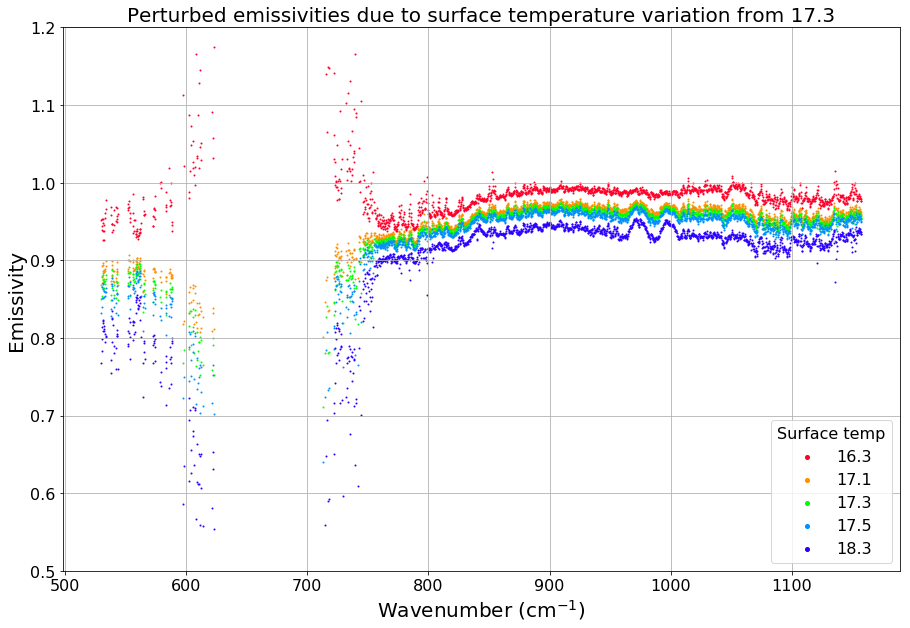

In [10]:
colors = cm.gist_rainbow(np.linspace(0, .8, 7)) # last number is number of colours you want

plt.figure(figsize=(15,10))
plt.scatter(a16[0],a16[1], s=1, label='16.3', c=colors[0])
plt.scatter(a1[0],a1[1], s=1, label='17.1', c=colors[1])
#plt.scatter(a2[0],a2[1], s=1, label='17.2', c=colors[2])
plt.scatter(a3[0],a3[1], s=1, label ='17.3', c=colors[3])
#plt.scatter(a4[0],a4[1], s=1, label='17.4', c=colors[4])
plt.scatter(a5[0],a5[1], s=1, label='17.5', c=colors[5])
plt.scatter(a18[0],a18[1], s=1, label='18.3', c=colors[6])
plt.title('Perturbed emissivities due to surface temperature variation from 17.3', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Surface temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.5,1.2)
plt.grid()
plt.show()

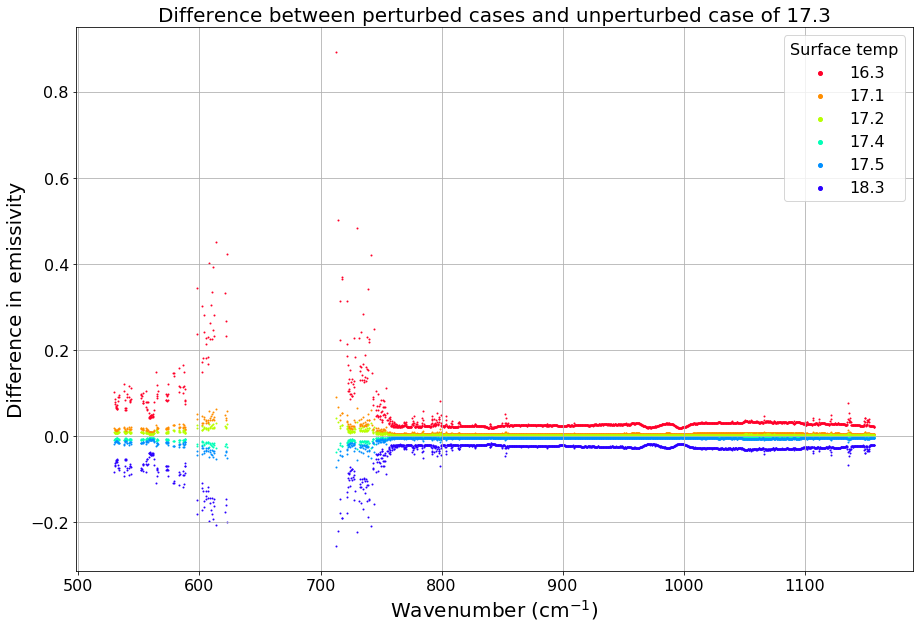

In [11]:
# Look at difference between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, 7)) # last number is number of colours you want

a1diff = [(a-b) for (a,b) in zip(a1[1],a3[1])]
a2diff = [(a-b) for (a,b) in zip(a2[1],a3[1])]
a4diff = [(a-b) for (a,b) in zip(a4[1],a3[1])]
a5diff = [(a-b) for (a,b) in zip(a5[1],a3[1])]
a18diff = [(a-b) for (a,b) in zip(a18[1],a3[1])]
a16diff = [(a-b) for (a,b) in zip(a16[1],a3[1])]

plt.figure(figsize=(15,10))
plt.scatter(a1[0],a16diff, s=1, label='16.3', c=colors[0])
plt.scatter(a1[0],a1diff, s=1, label='17.1', c=colors[1])
plt.scatter(a1[0],a2diff, s=1, label='17.2', c=colors[2])
plt.scatter(a1[0],a4diff, s=1, label='17.4', c=colors[4])
plt.scatter(a1[0],a5diff, s=1, label='17.5', c=colors[5])
plt.scatter(a1[0],a18diff, s=1, label='18.3', c=colors[6])
plt.title('Difference between perturbed cases and unperturbed case of 17.3', fontsize=20)
plt.ylabel('Difference in emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Surface temp', markerscale=4)
plt.setp(legend.get_title(), fontsize=16)

#plt.ylim(0,1)
plt.grid()
plt.show()

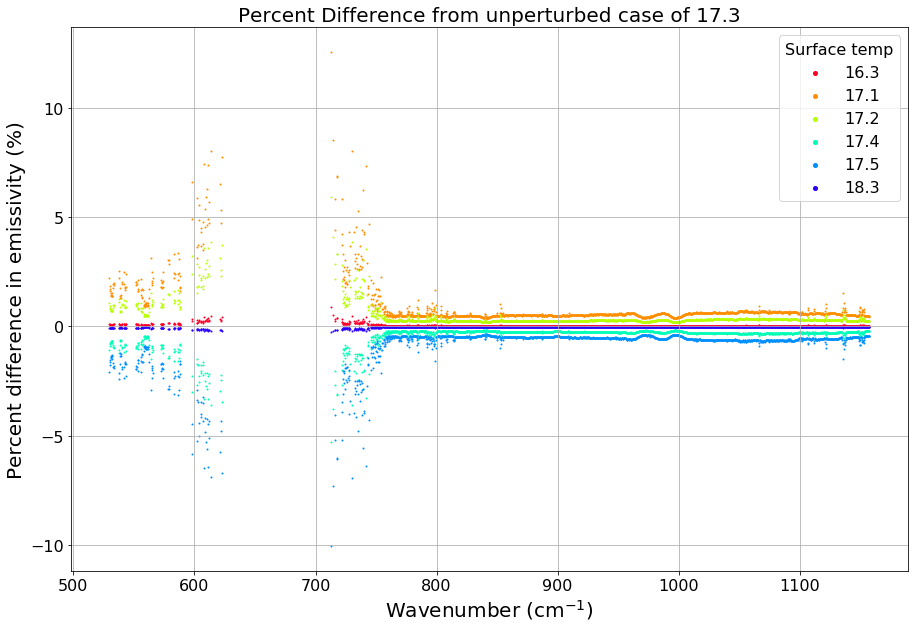

In [12]:
# Look at percentage deviation between each perturbation and the unperturbed one
colors = cm.gist_rainbow(np.linspace(0, .8, 7)) # last number is number of colours you want


a1perc = [(a-b)/b*100 for (a,b) in zip(a1[1],a3[1])]
a2perc = [(a-b)/b*100 for (a,b) in zip(a2[1],a3[1])]
a4perc = [(a-b)/b*100 for (a,b) in zip(a4[1],a3[1])]
a5perc = [(a-b)/b*100 for (a,b) in zip(a5[1],a3[1])]
a18perc = [(a-b)/b*100 for (a,b) in zip(a18[1],a3[1])]
a16perc = [(a-b)/b*100 for (a,b) in zip(a16[1],a3[1])]

plt.figure(figsize=(15,10))
plt.scatter(a18[0],a16diff, s=1, label='16.3', c=colors[0])
plt.scatter(a1[0],a1perc, s=1, label='17.1', c=colors[1])
plt.scatter(a2[0],a2perc, s=1, label='17.2', c=colors[2])
plt.scatter(a3[0],a4perc, s=1, label='17.4', c=colors[4])
plt.scatter(a4[0],a5perc, s=1, label='17.5', c=colors[5])
plt.scatter(a5[0],a18diff, s=1, label='18.3', c=colors[6])
plt.title('Percent Difference from unperturbed case of 17.3', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Surface temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
plt.show()

In [13]:
with open(os.path.join(path_sensitivity, 'Atm_T_' + str(atm_t) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))

In [14]:
b1 = read_file(path_sensitivity, 'Atm_T_20.93.csv', separator='\t', rowstoskip=None, head=None)
b2 = read_file(path_sensitivity, 'Atm_T_21.03.csv', separator='\t', rowstoskip=None, head=None)
b3 = read_file(path_sensitivity, 'Atm_T_21.13.csv', separator='\t', rowstoskip=None, head=None)

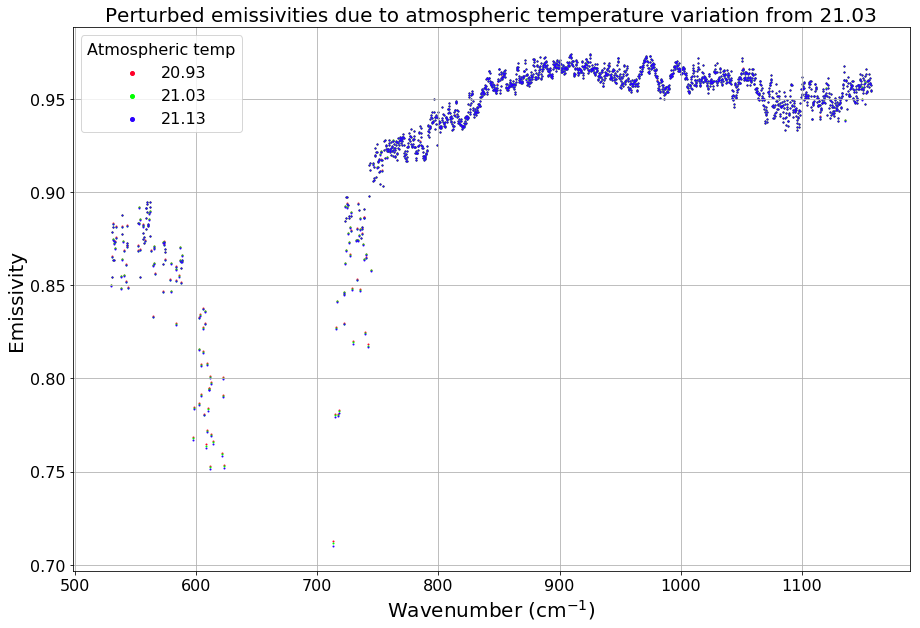

In [15]:
colors = cm.gist_rainbow(np.linspace(0, .8, 3)) # last number is number of colours you want

plt.figure(figsize=(15,10))
plt.scatter(b1[0],b1[1], s=1, label='20.93', c=colors[0])
plt.scatter(b1[0],b2[1], s=1, label='21.03', c=colors[1])
plt.scatter(b1[0],b3[1], s=1, label='21.13', c=colors[2])

plt.title('Perturbed emissivities due to atmospheric temperature variation from 21.03', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Atmospheric temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
#plt.ylim(0.5,1.2)
plt.grid()
plt.show()

In [16]:
#Not very sensitive to atmospheric temperature!! Try with bigger temperature variations:

In [17]:
b2 = read_file(path_sensitivity, 'Atm_T_21.03.csv', separator='\t', rowstoskip=None, head=None)
b4 = read_file(path_sensitivity, 'Atm_T_22.03.csv', separator='\t', rowstoskip=None, head=None)
b5 = read_file(path_sensitivity, 'Atm_T_23.03.csv', separator='\t', rowstoskip=None, head=None)
b6 = read_file(path_sensitivity, 'Atm_T_20.03.csv', separator='\t', rowstoskip=None, head=None)
b7 = read_file(path_sensitivity, 'Atm_T_19.03.csv', separator='\t', rowstoskip=None, head=None)
b8 = read_file(path_sensitivity, 'Atm_T_10.03.csv', separator='\t', rowstoskip=None, head=None)

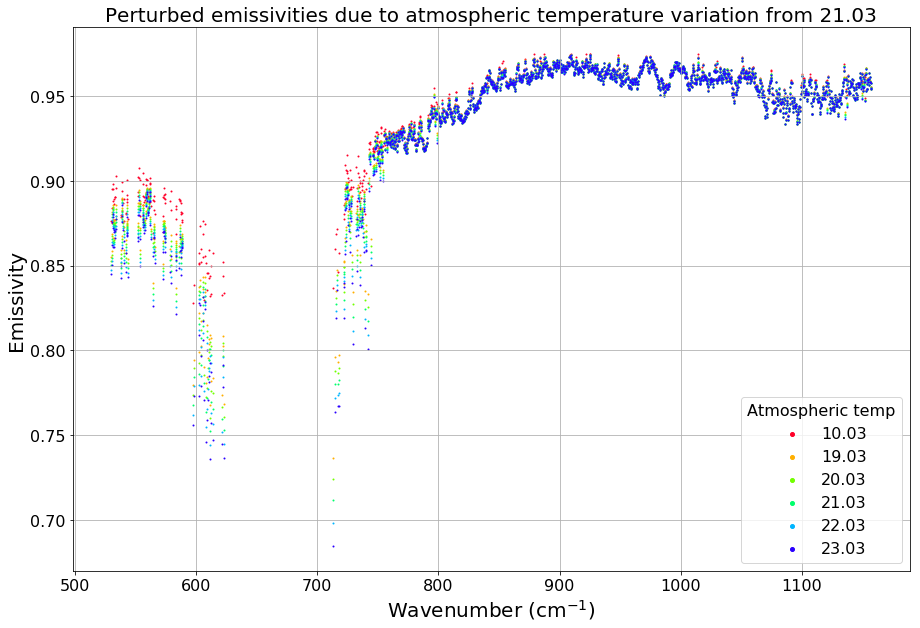

In [18]:
colors = cm.gist_rainbow(np.linspace(0, .8, 6)) # last number is number of colours you want

plt.figure(figsize=(15,10))
plt.scatter(b1[0],b8[1], s=1, label='10.03', c=colors[0])
plt.scatter(b1[0],b7[1], s=1, label='19.03', c=colors[1])
plt.scatter(b1[0],b6[1], s=1, label='20.03', c=colors[2])
plt.scatter(b1[0],b2[1], s=1, label='21.03', c=colors[3])
plt.scatter(b1[0],b4[1], s=1, label='22.03', c=colors[4])
plt.scatter(b1[0],b5[1], s=1, label='23.03', c=colors[5])
plt.title('Perturbed emissivities due to atmospheric temperature variation from 21.03', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Atmospheric temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
#plt.ylim(0.5,1.2)
plt.grid()

plt.show()

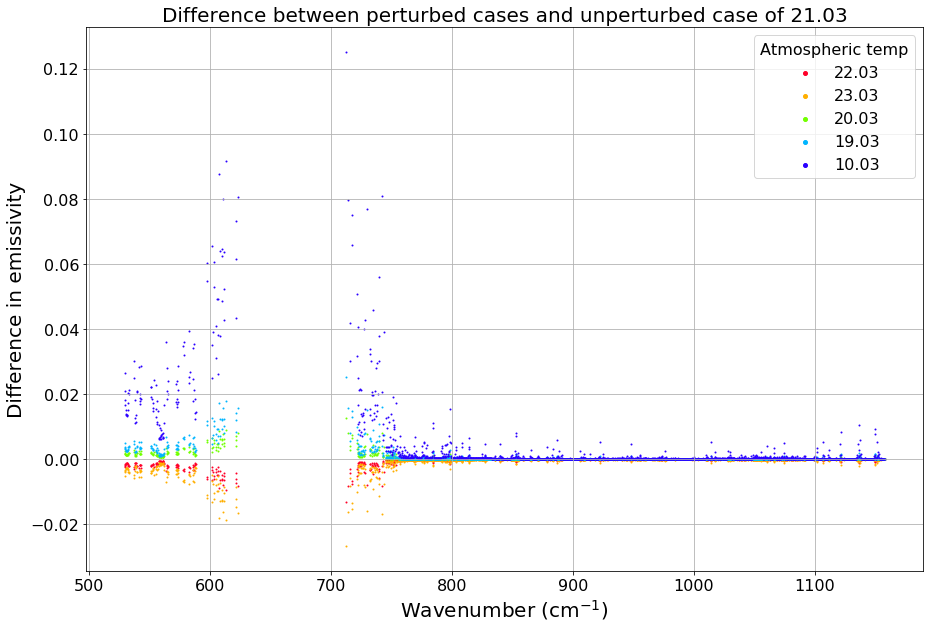

In [19]:
# Look at difference between each perturbation and the unperturbed one
colors = cm.gist_rainbow(np.linspace(0, .8, 6)) # last number is number of colours you want


b4diff = [(a-b) for (a,b) in zip(b4[1],b2[1])]
b5diff = [(a-b) for (a,b) in zip(b5[1],b2[1])]
b6diff = [(a-b) for (a,b) in zip(b6[1],b2[1])]
b7diff = [(a-b) for (a,b) in zip(b7[1],b2[1])]
b8diff = [(a-b) for (a,b) in zip(b8[1],b2[1])]

plt.figure(figsize=(15,10))
plt.scatter(b1[0],b4diff, s=1, label='22.03', c=colors[0])
plt.scatter(b1[0],b5diff, s=1, label='23.03', c=colors[1])
plt.scatter(b1[0],b6diff, s=1, label='20.03', c=colors[2])
plt.scatter(b1[0],b7diff, s=1, label='19.03', c=colors[4])
plt.scatter(b1[0],b8diff, s=1, label='10.03', c=colors[5])

plt.title('Difference between perturbed cases and unperturbed case of 21.03', fontsize=20)
plt.ylabel('Difference in emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Atmospheric temp', markerscale=4)
plt.setp(legend.get_title(), fontsize=16)

#plt.ylim(0,1)
plt.grid()
plt.show()

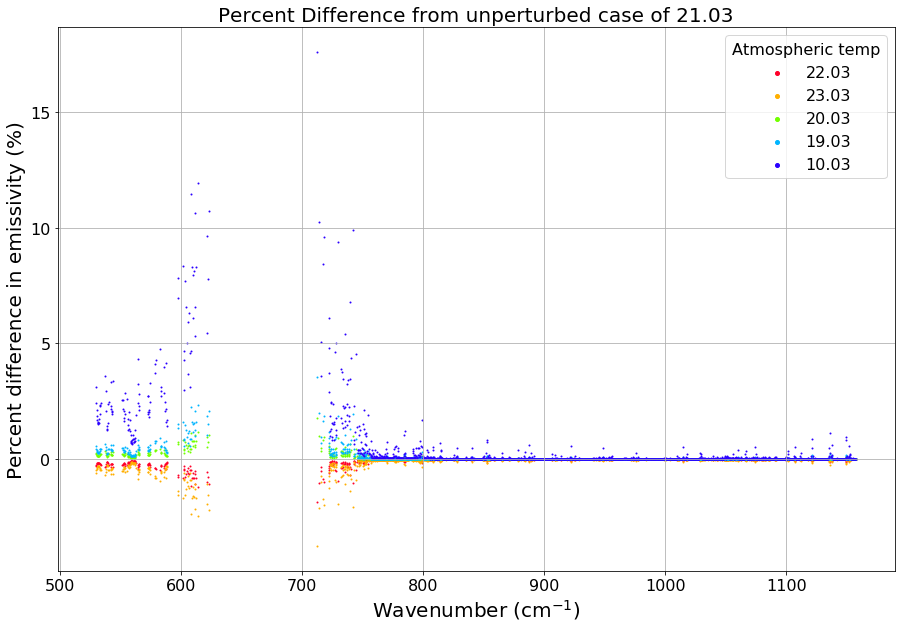

In [20]:
# Look at percentage deviation between each perturbation and the unperturbed one
colors = cm.gist_rainbow(np.linspace(0, .8, 6)) # last number is number of colours you want

b4perc = [(a-b)/b*100 for (a,b) in zip(b4[1],b2[1])]
b5perc = [(a-b)/b*100 for (a,b) in zip(b5[1],b2[1])]
b6perc = [(a-b)/b*100 for (a,b) in zip(b6[1],b2[1])]
b7perc = [(a-b)/b*100 for (a,b) in zip(b7[1],b2[1])]
b8perc = [(a-b)/b*100 for (a,b) in zip(b8[1],b2[1])]

plt.figure(figsize=(15,10))
plt.scatter(b4[0],b4perc, s=1, label='22.03', c=colors[0])
plt.scatter(b5[0],b5perc, s=1, label='23.03', c=colors[1])
plt.scatter(b6[0],b6perc, s=1, label='20.03', c=colors[2])
plt.scatter(b7[0],b7perc, s=1, label='19.03', c=colors[4])
plt.scatter(b8[0],b8perc, s=1, label='10.03', c=colors[5])
plt.title('Percent Difference from unperturbed case of 21.03', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Atmospheric temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
plt.show()